<a href="https://colab.research.google.com/github/romiebanerjee/mmsegmentation-bayes/blob/main/mmlab_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation-bayes tools tutorial on Colab

In this tutorial, we will introduce the following content:

* How to install mmseg-bayes
* Fetch a pre-trained mmseg model
* Prepare data for Fisher estimation
* Make the BNN model from pre-trained model and Fisher
* Run example to compute post-hoc uncertainties

## Install mmseg-bayes

Before using mmseg-bayes, we need to prepare the environment with the following steps:

1. Install Python, CUDA, C/C++ compiler and git
2. Install PyTorch (CUDA version)
3. Install mmcv
4. Install mmengine-bayes

Because this tutorial is on Google Colab, and the basic environment has been completed, we can skip the first two steps.

### Check Environment

In [1]:
%cd /content

/content


In [2]:
!pwd

/content


In [3]:
#check nvcc version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [4]:
# Check GCC version
!gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [5]:
# Check PyTorch installation
import torch, torchvision
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu124
True


In [6]:
import torch
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Install MMCV

MMCV is the basic package of all OpenMMLab packages. We have pre-built wheels on Linux, so we can download and install them directly.

Please pay attention to PyTorch and CUDA versions to match the wheel.

In the above steps, we have checked the version of PyTorch and CUDA, and they are 2.6.0 and 12.4 respectively, so we need to choose the corresponding wheel.

In addition, we can also install the full version of mmcv (mmcv-full). It includes full features and various CUDA ops out of the box, but needs a longer time to build.

In [ ]:
!pip install ftfy cityscapesscripts

In [1]:
# For CUDA 11.8 + PyTorch 2.0+
!pip install -U openmim
!mim install mmcv #WARNING: this might take upto 40 mins!

Looking in links: https://download.openmmlab.com/mmcv/dist/cu124/torch2.6.0/index.html
Could not fetch URL https://download.openmmlab.com/mmcv/dist/cu124/torch2.6.0/index.html: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='download.openmmlab.com', port=443): Max retries exceeded with url: /mmcv/dist/cu124/torch2.6.0/index.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1016)'))) - skipping
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.1/479.1 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Could not fetch URL https://download.openmmlab.com/mmcv/dist/cu124/torch2.6.0/index.html: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='download.openmmlab.com', port=443): Max retries exceeded with url: /mmcv/dist/cu124/torch2.6.0/index.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED]

### Clone and install mmengine-bayes and mmsegmentation-bayes

In [2]:
!git clone https://github.com/romiebanerjee/mmengine-bayes
!pip install -e mmengine-bayes/.

fatal: destination path 'mmengine-bayes' already exists and is not an empty directory.
Obtaining file:///content/mmengine-bayes
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmengine
    Found existing installation: mmengine 0.10.7
    Uninstalling mmengine-0.10.7:
      Successfully uninstalled mmengine-0.10.7
  Running setup.py develop for mmengine


In [3]:
!git clone https://github.com/romiebanerjee/mmsegmentation-bayes
!pip install -e mmsegmentation-bayes/.

Cloning into 'mmsegmentation-bayes'...
remote: Enumerating objects: 14870, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 14870 (delta 40), reused 47 (delta 22), pack-reused 14798 (from 1)
Receiving objects: 100% (14870/14870), 42.83 MiB | 41.33 MiB/s, done.
Resolving deltas: 100% (10713/10713), done.
Obtaining file:///content/mmsegmentation-bayes
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [2]:
import sys
sys.path.append('/content/mmsegmentation-bayes/')
sys.path.append('/content/mmengine-bayes/')
import mmcv, mmengine, mmseg

## Laplace Approximation with KFAC

### Download a pre-trained model from MMSeg

In [ ]:
!wget --no-check-certificate https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r50-d8_512x1024_40k_cityscapes/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth


In [8]:
import torch
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!mkdir /content/mmsegmentation-bayes/checkpoints/
!cp -rv /content/drive/MyDrive/data/checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth /content/mmsegmentation-bayes/checkpoints/
!cp -rv /content/drive/MyDrive/data/work_dirs/deeplabv3plus_r50-d8_4xb2-40k_cityscapes-512x1024/kfac_state_iter_latest.pt /content/mmsegmentation-bayes/checkpoints/

mkdir: cannot create directory ‘/content/mmsegmentation-bayes/checkpoints/’: File exists
'/content/drive/MyDrive/data/checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth' -> '/content/mmsegmentation-bayes/checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth'
'/content/drive/MyDrive/data/work_dirs/deeplabv3plus_r50-d8_4xb2-40k_cityscapes-512x1024/kfac_state_iter_latest.pt' -> '/content/mmsegmentation-bayes/checkpoints/kfac_state_iter_latest.pt'


### Prepare training data for estimating Fisher

In [ ]:
!pwd
!mkdir /content/mmsegmentation-bayes/data/
!ln -s /content/drive/MyDrive/data/cityscapes /content/mmsegmentation-bayes/data/

In [ ]:
!pwd
#--nproc means 8 process for conversion, which could be omitted as well.
!python mmsegmentation-bayes/tools/dataset_converters/cityscapes.py mmsegmentation-bayes/data/cityscapes --nproc 8

### Estimate Fisher

In [ ]:
%cd mmsegmentation-bayes
!pwd
!python tools/fisher.py './configs/deeplabv3plus/deeplabv3plus_r50-d8_4xb2-40k_cityscapes-512x1024.py' \
 --cfg-options load_from="checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth" device="cuda"

## Use BNN for predictive *distributions*

In [5]:
from mmseg.apis import inference_model, init_model, show_result_pyplot
from mmengine.curvature import KFAC
from mmseg.apis import SegGLM

In [6]:
config_path = '/content/mmsegmentation-bayes/configs/deeplabv3plus/deeplabv3plus_r50-d8_4xb2-40k_cityscapes-512x1024.py'
model_path =  '/content/mmsegmentation-bayes/checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth'
curvature_checkpoint = '/content/mmsegmentation-bayes/checkpoints/kfac_state_iter_latest.pt'

In [9]:
myglm = SegGLM(model_checkpoint = model_path, config = config_path, device = device, curvature_checkpoint= curvature_checkpoint)

Loading base model ... 


/content/mmsegmentation-bayes/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /content/mmsegmentation-bayes/checkpoints/deeplabv3plus_r50-d8_512x1024_40k_cityscapes_20200605_094610-d222ffcd.pth
Initiating KFAC object ...
Calculating eigenvalues of the fisher


72it [00:40,  1.76it/s]


Computing inverted Cholesky of fisher ...


72it [12:42, 10.59s/it]


In [14]:
torch.save(myglm.kfac.invchol, '/content/drive/MyDrive/data/work_dirs/deeplabv3plus_r50-d8_4xb2-40k_cityscapes-512x1024/invchol.pt')

/content/mmengine-bayes/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


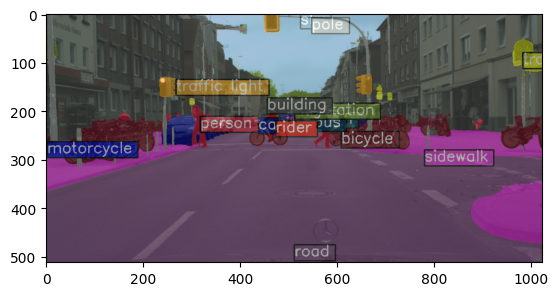

In [10]:
# show the results
from matplotlib import pyplot as plt

img = '/content/mmsegmentation-bayes/demo/demo.png'
output_path = '/content/mmsegmentation-bayes/demo/seg_output.png'

result = inference_model(myglm.model, img)
vis_result = show_result_pyplot(myglm.model, img, result, show=False)
plt.imshow(vis_result)

In [ ]:
seg_unc = myglm.mcglm_predictive(image = img, eps = 1e-6, iters = 10, eig_idx = None)

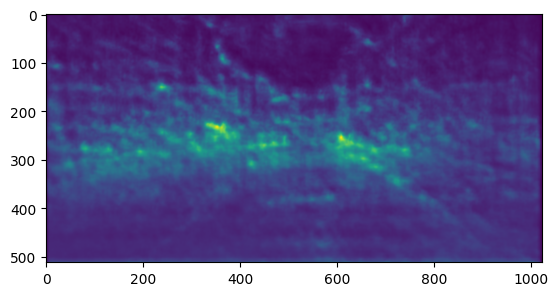

In [14]:
plt.imshow(seg_unc.detach().cpu().squeeze())